In [2]:
# datapath="/dataa/Dataset/fake_or_real/for-norm"
# datapaht="/dataa/Dataset/adv"
from tqdm import tqdm
from pathlib import Path
import shutil
import pandas as pd

In [3]:
df = pd.read_csv("/dataa/Dataset/ASVspoof/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt",sep=" ",header=None)

In [4]:
df.head

<bound method NDFrame.head of              0             1  2    3         4
0      LA_0039  LA_E_2834763  -  A11     spoof
1      LA_0014  LA_E_8877452  -  A14     spoof
2      LA_0040  LA_E_6828287  -  A16     spoof
3      LA_0022  LA_E_6977360  -  A09     spoof
4      LA_0031  LA_E_5932896  -  A13     spoof
...        ...           ... ..  ...       ...
71232  LA_0004  LA_E_1665632  -    -  bonafide
71233  LA_0038  LA_E_5085671  -  A09     spoof
71234  LA_0012  LA_E_4926022  -  A16     spoof
71235  LA_0052  LA_E_2894498  -    -  bonafide
71236  LA_0009  LA_E_4689563  -  A19     spoof

[71237 rows x 5 columns]>

In [9]:
# mypath = Path("/dataa/Dataset/fake_or_real/for-norm/")
mypath = Path("/dataa/Dataset/adv")
emb_paths = mypath.rglob("*_adv.wav")
emb_paths
list_file = []
for f in tqdm(emb_paths):
    relative_path = f.relative_to(mypath)
    _, name = str(relative_path).split("/")
    name = name.replace("_adv.wav",".wav")
    shutil.copyfile(f, "/dataa/Dataset/full_adv/{}".format(name))
    # subset, label, name = str(relative_path).split("/")
    # list_file.append(str(relative_path)+" {} {}\n".format(subset, label))b
    

8849it [00:03, 2453.94it/s]


In [20]:
spk_id=df.loc[df[1]=="LA_E_4689563"][0]

In [22]:
spk_id

'71236    LA_0009\nName: 0, dtype: object'

In [12]:
# df.loc[df[1]=="LA_E_4689563"][4]
mypath = Path("/dataa/Dataset/full_adv")
emb_paths = mypath.rglob("*.wav")
list_file = []
for f in tqdm(emb_paths):
    relative_path = f.relative_to(mypath)
    # _, name = str(relative_path).split("/")
    name = str(relative_path).replace(".wav","")
    list_file.append(name)

8207it [00:00, 63483.26it/s]


In [28]:
df.loc[df[1]=="LA_E_4689563"].values[0]


array(['LA_0009', 'LA_E_4689563', '-', 'A19', 'spoof'], dtype=object)

In [33]:
with open("adv_key.txt", "w") as f:
    for i in list_file:
        row = df.loc[df[1]==i].values[0]
        spk_id = row[0]
        utt = row[1]
        phy = row[2]
        sys_id = row[3]
        label = row[4]
        f.write("{} {}.wav - - {} {} - eval\n".format(spk_id, utt,sys_id, label))

In [32]:
with open("adv_protocol.txt", "w") as f:
    for i in list_file:
        row = df.loc[df[1]==i].values[0]
        spk_id = row[0]
        utt = row[1]
        phy = row[2]
        sys_id = row[3]
        label = row[4]
        f.write("{}.wav eval {}\n".format(utt, label))

In [12]:
import random
random.shuffle(list_file)

In [13]:
list_file
with open("/dataa/Dataset/fake_or_real/for-norm/key.txt", "w") as f:
    f.writelines(list_file)

In [14]:
data=[]
with open("protocol.txt", "r") as f:
    data = f.readlines()

In [20]:
with open("/dataa/Dataset/fake_or_real/for-norm/key.txt", "w") as f:
    for i in data:
        key, subset, label = i.strip().split(" ")
        label = "spoof" if label=="fake" else "bonafide"
        f.write("- {} - - - {} - {}\n".format(key, label, subset))
    


# Track 3 ADD2023

In [ ]:
from mchad import MCHAD
model = MCHAD()

# RESULT CALCULATION

In [1]:
import torch
import torchvision.transforms as tvt
from torch.utils.data import DataLoader
from tqdm import tqdm
import shutil
import pandas as pd
import numpy as np
import os
torch.manual_seed(1234)
from eval_metric_LA import compute_eer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/home/phucdt/anaconda3/envs/SSL_Spoofing/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## SDS2023

In [2]:
# load SDS2023 protocol

sds2023 = pd.read_csv("/dataa/phucdt/vocodetect/traindata/SDS2023/protocol.txt", sep=" ", header=None)
sds2023.columns = ['utt', 'subset', 'label']
sds2023.head
# sds2023['label'] = sds2023['utt'].apply(lambda x: "spoof" if "Fake" in x.split('/')[0] else "bonafide")
# sds2023.to_csv("../traindata/SDS2023/protocol.txt",sep= ' ', index=False, header=False)

<bound method NDFrame.head of                                      utt subset     label
0      Datasets_Real/real/real_00001.wav   eval  bonafide
1      Datasets_Real/real/real_00002.wav   eval  bonafide
2      Datasets_Real/real/real_00003.wav   eval  bonafide
3      Datasets_Real/real/real_00004.wav   eval  bonafide
4      Datasets_Real/real/real_00005.wav   eval  bonafide
...                                  ...    ...       ...
82963   Datasets_Fake/WaveGlow_13096.wav   eval     spoof
82964   Datasets_Fake/WaveGlow_13097.wav   eval     spoof
82965   Datasets_Fake/WaveGlow_13098.wav   eval     spoof
82966   Datasets_Fake/WaveGlow_13099.wav   eval     spoof
82967   Datasets_Fake/WaveGlow_13100.wav   eval     spoof

[82968 rows x 3 columns]>

EER: 6.2698%, threshold: -3.3832


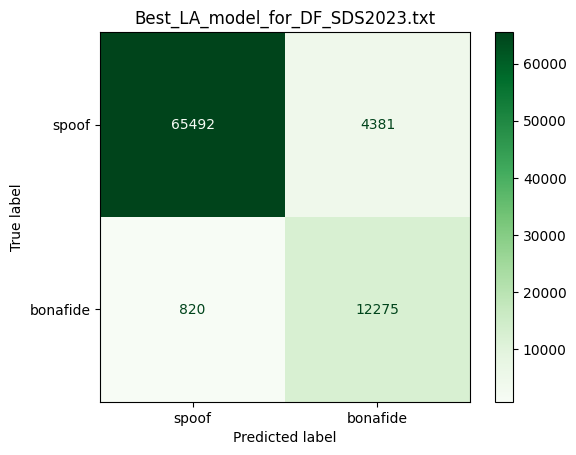

In [5]:
pred_df = pd.read_csv("res/Best_LA_model_for_DF_SDS2023.txt", sep=" ", header=None)
pred_df.columns = ["utt", "score"]

# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(sds2023, pred_df, on='utt')
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("Best_LA_model_for_DF_SDS2023.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

## In The Wild

In [6]:
# load in the wild protocol
in_the_wild = pd.read_csv("/dataa/phucdt/vocodetect/traindata/in_the_wild/protocol.txt", sep=" ", header=None)
in_the_wild.columns = ['utt', 'subset', 'label']
in_the_wild.head

<bound method NDFrame.head of                  utt subset     label
0          wav/1.wav   eval     spoof
1          wav/2.wav   eval     spoof
2          wav/3.wav   eval     spoof
3          wav/4.wav   eval  bonafide
4          wav/5.wav   eval  bonafide
...              ...    ...       ...
31773  wav/31774.wav   eval  bonafide
31774  wav/31775.wav   eval  bonafide
31775  wav/31776.wav   eval  bonafide
31776  wav/31777.wav   eval  bonafide
31777  wav/31778.wav   eval     spoof

[31778 rows x 3 columns]>

EER: 10.4788%, threshold: -3.5562


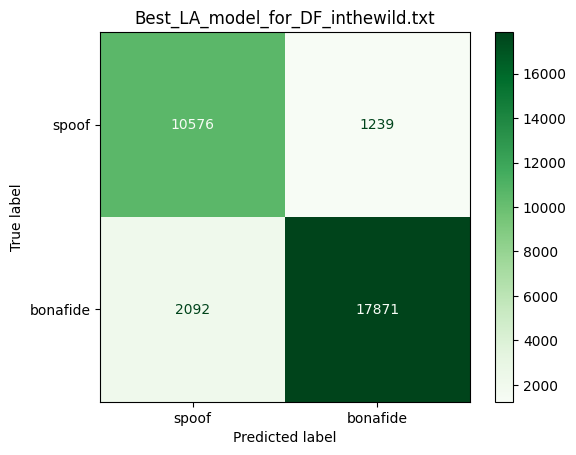

In [8]:
pred_df = pd.read_csv("res/Best_LA_model_for_DF_inthewild.txt", sep=" ", header=None)
pred_df.columns = ["utt", "score"]

# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(in_the_wild, pred_df, on='utt')
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("Best_LA_model_for_DF_inthewild.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

## ASVspoof 2019 eval

In [10]:
# load evaluation protocol
# load SDS2023 protocol

eval_df = pd.read_csv("/datab/Dataset/ASVspoof/LA/ASVspoof2019_LA_eval/protocol.txt", sep=" ", header=None)
eval_df.columns = ['utt', 'subset', 'label']
eval_df.head
# sds2023['label'] = sds2023['utt'].apply(lambda x: "spoof" if "Fake" in x.split('/')[0] else "bonafide")
# sds2023.to_csv("../traindata/SDS2023/protocol.txt",sep= ' ', index=False, header=False)

<bound method NDFrame.head of                           utt subset     label
0      flac/LA_E_8877452.flac   eval     spoof
1      flac/LA_E_6828287.flac   eval     spoof
2      flac/LA_E_6977360.flac   eval     spoof
3      flac/LA_E_5932896.flac   eval     spoof
4      flac/LA_E_5849185.flac   eval  bonafide
...                       ...    ...       ...
71231  flac/LA_E_1665632.flac   eval  bonafide
71232  flac/LA_E_5085671.flac   eval     spoof
71233  flac/LA_E_4926022.flac   eval     spoof
71234  flac/LA_E_2894498.flac   eval  bonafide
71235  flac/LA_E_4689563.flac   eval     spoof

[71236 rows x 3 columns]>

EER: 0.1499%, threshold: 1.7131


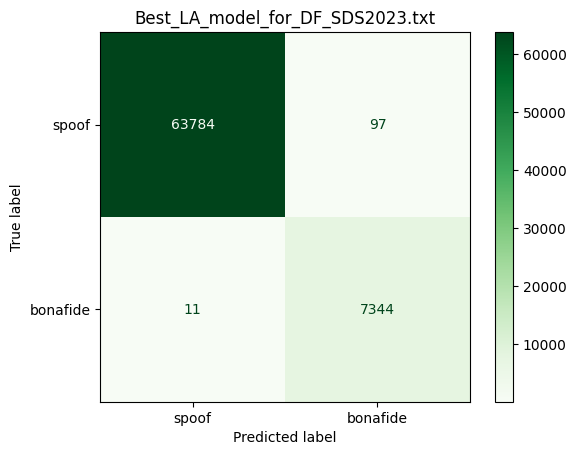

In [11]:
pred_df = pd.read_csv("res/Best_LA_model_for_DF_asvspoof2019.txt", sep=" ", header=None)
pred_df.columns = ["utt", "score"]

# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(eval_df, pred_df, on='utt')
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("Best_LA_model_for_DF_SDS2023.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()